# Overview
This workbook does the following:


1.   Import Raw Data
2.   Create a all_func_grouped DF
3.   Creates a dictionary of DFs for all the sub functions



In [1]:
# Only for Google Colab

from google.colab import drive
drive.mount('/content/drive')

# Only run if you don't have the converted data yet
# with open( '/content/drive/MyDrive/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt', 'r') as source:
#   with open( '/content/drive/MyDrive/AzureFunctionsInvocationTraceForTwoWeeksJan2021.csv',
# 'w') as target:
#     target.write(source. read())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
import datetime
import tensorflow as tf
plt.rcParams['figure.figsize'] = (50, 20)  # Set figure size

# Data Preparation
Now we have to download the data, build a combined dataset,
a func-specific dataset, and then split each one of these into training, validation and test subsets.

In [3]:
# Read in the raw data, then create a time value based on the end_timestamp
# df = pd.read_csv("/content/drive/MyDrive/small_data_no_head.csv")
df = pd.read_csv("/content/drive/MyDrive/AzureFunctionsInvocationTraceForTwoWeeksJan2021.csv")

df['time'] = [datetime.datetime(2021,1,31) + datetime.timedelta(seconds=x) for x in df['end_timestamp']]

# Dataframe summarized
print(f"Number of Unique Applications: {len(set(df['func']))}")
df.info()
df.head()


Number of Unique Applications: 424
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980951 entries, 0 to 1980950
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   app            object        
 1   func           object        
 2   end_timestamp  float64       
 3   duration       float64       
 4   time           datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 75.6+ MB


,app,func,end_timestamp,duration,time
0,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,0.079491,0.078,2021-01-31 00:00:00.079491
1,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,57.157860,57.154,2021-01-31 00:00:57.157860
2,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,59.130478,59.125,2021-01-31 00:00:59.130478
3,f274d71de386ccc77e4ca74766dbc485461c3053059d47...,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,6.252541,6.236,2021-01-31 00:00:06.252541
4,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,0.066824,0.050,2021-01-31 00:00:00.066824


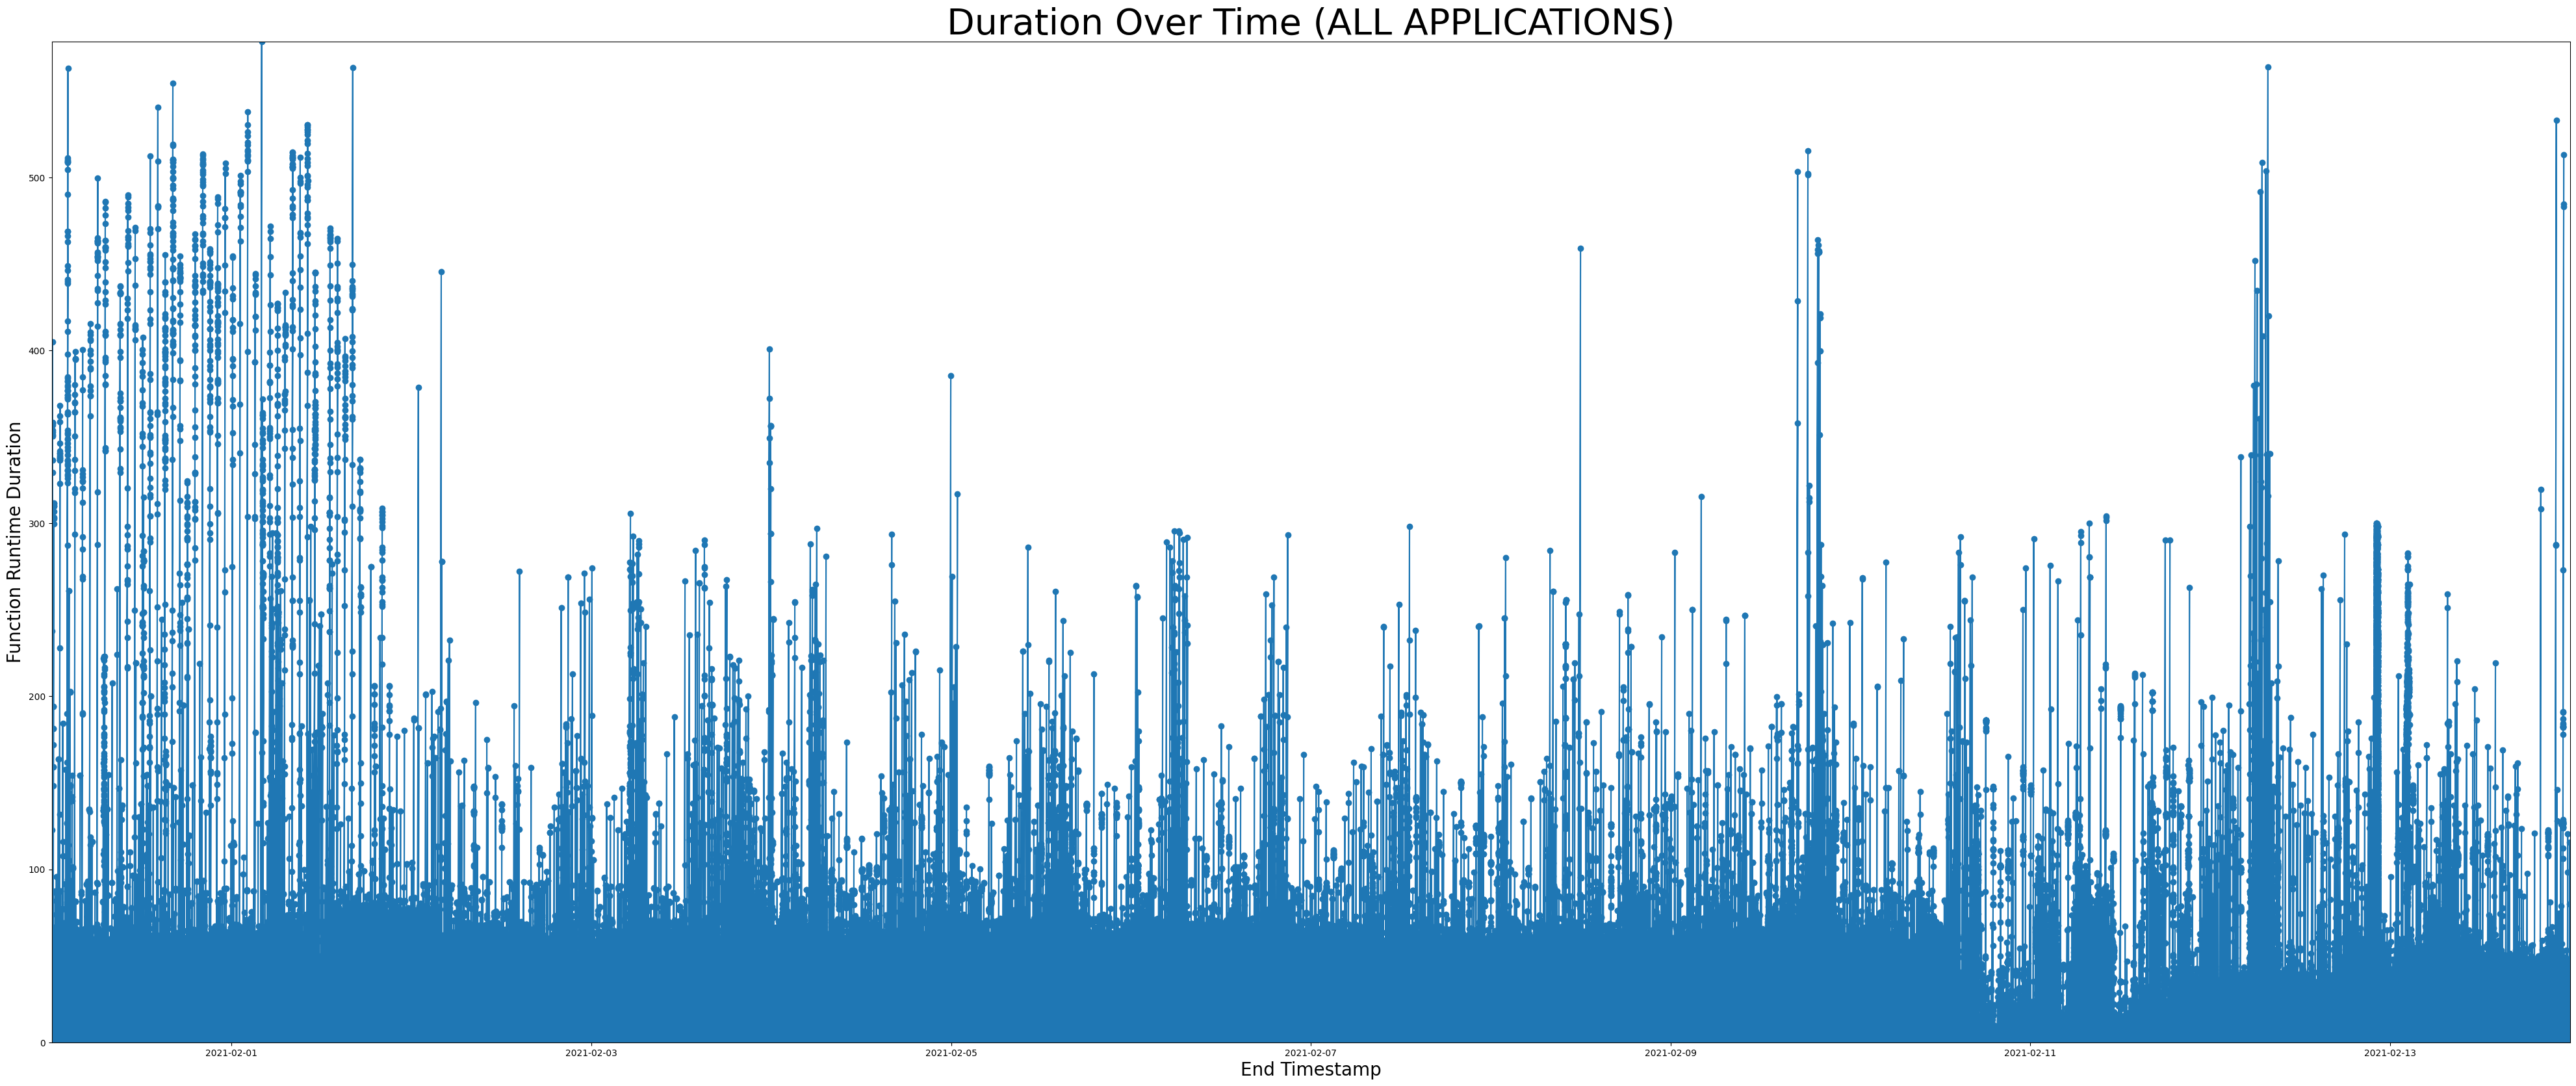

In [4]:
# Plotting Raw Data

plt.plot(df['time'], df['duration'], 'o-')
ax = plt.gca()
ax.set_xlim([min(df['time']), max(df['time'])])
ax.set_ylim([min(df['duration']), max(df['duration'])])
plt.title('Duration Over Time (ALL APPLICATIONS)',  fontsize=40)
plt.xlabel('End Timestamp', fontsize=20)
plt.ylabel('Function Runtime Duration', fontsize=20)
plt.show()

## Preparing the all_func_grouped
Now we need to convert this format to a time series usable format

In [5]:
# We need to bin all the data

# Bin the timestamps into 10-minute intervals
df['time_bin'] = df['time'].dt.floor('10T')  # Floor the timestamps to the nearest 10 minutes

# Group by these intervals and count the number of instances
all_func_grouped = df.groupby('time_bin').size().reset_index(name='count')

# Set the intervals as the index (optional)
all_func_grouped.set_index('time_bin', inplace=True)

all_func_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2021-01-31 00:00:00 to 2021-02-13 23:50:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   2016 non-null   int64
dtypes: int64(1)
memory usage: 31.5 KB


<ipython-input-5-8477c613f14f>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['time_bin'] = df['time'].dt.floor('10T')  # Floor the timestamps to the nearest 10 minutes


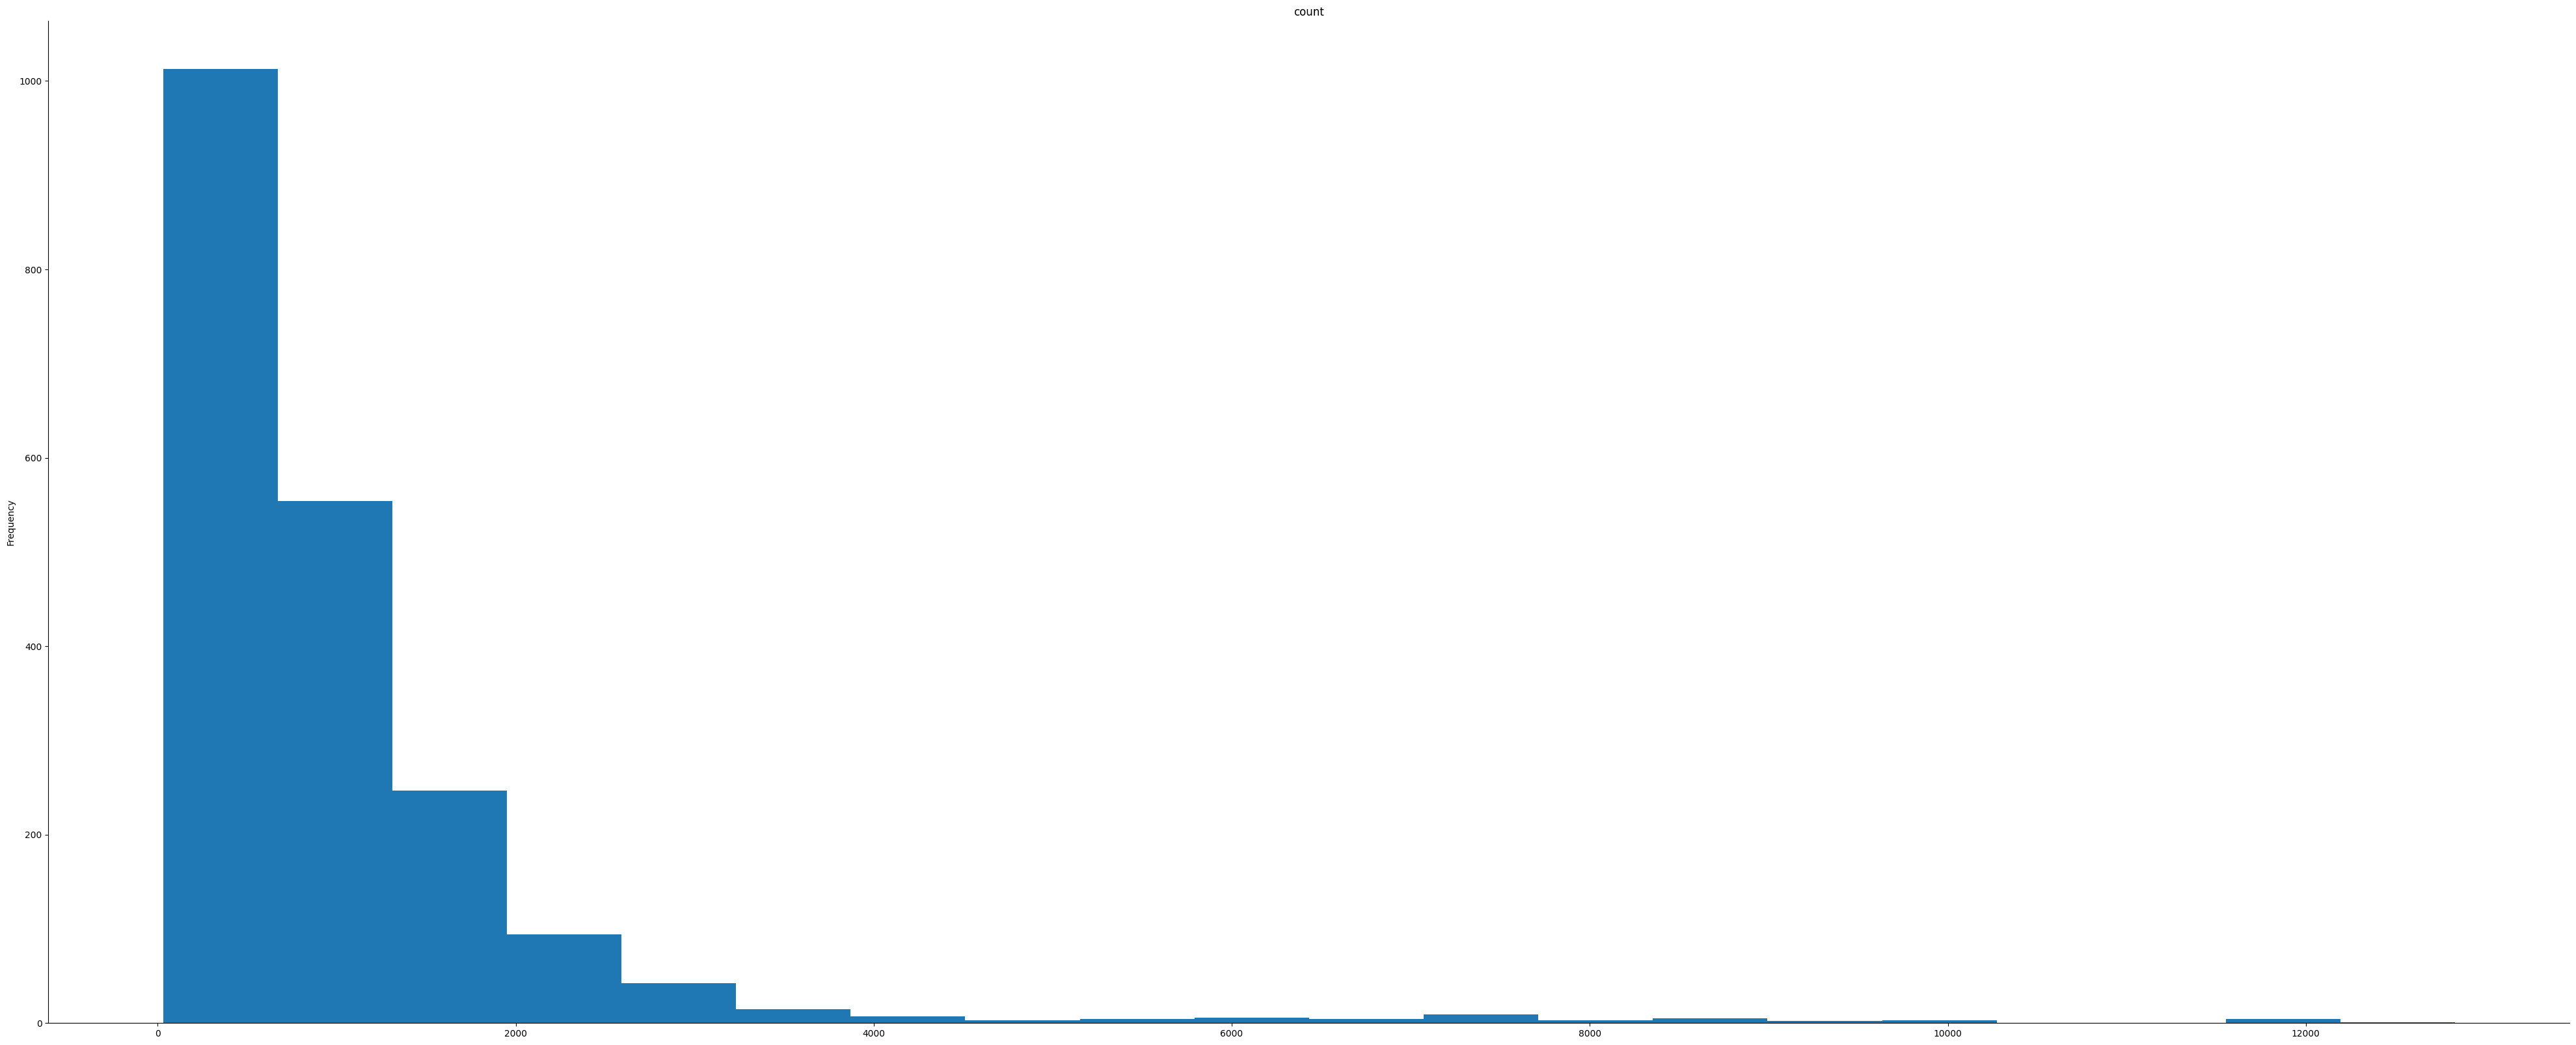

In [6]:
# Distribution of the number of instances per bin
all_func_grouped['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

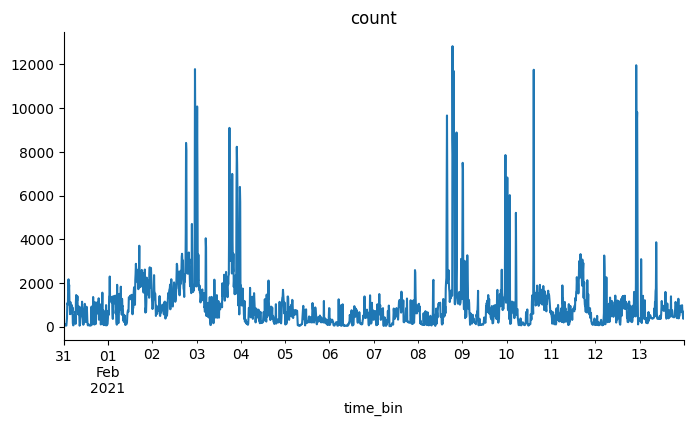

In [7]:
# Number of instances over time, this is what we really want to predict
all_func_grouped['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

## Duration Dataset Conversion
Here we need to convert the dataset into a time series format
with the duration as the only feature space.

In [15]:
# Set 'time' as the index

duration_df = df[['duration', 'time']]
duration_df.set_index('time', inplace=True)

# Resample to equally spaced time bins (e.g., 10 minutes)
resampled_df = duration_df.resample('10T').mean()  # '10T' = 10-minute bins


# Handle missing bins (optional)
resampled_df['duration'] = resampled_df['duration'].fillna(0)  # Fill with 0
resampled_df.info()
resampled_df


<ipython-input-15-5f154f489a7d>:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_df = duration_df.resample('10T').mean()  # '10T' = 10-minute bins


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2021-01-31 00:00:00 to 2021-02-13 23:50:00
Freq: 10min
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  2016 non-null   float64
dtypes: float64(1)
memory usage: 31.5 KB


,duration
time,
2021-01-31 00:00:00,55.728184
2021-01-31 00:10:00,52.744311
2021-01-31 00:20:00,7.938605
2021-01-31 00:30:00,7.149630
2021-01-31 00:40:00,10.520867
...,...
2021-02-13 23:10:00,2.604828
2021-02-13 23:20:00,0.643820
2021-02-13 23:30:00,0.928829


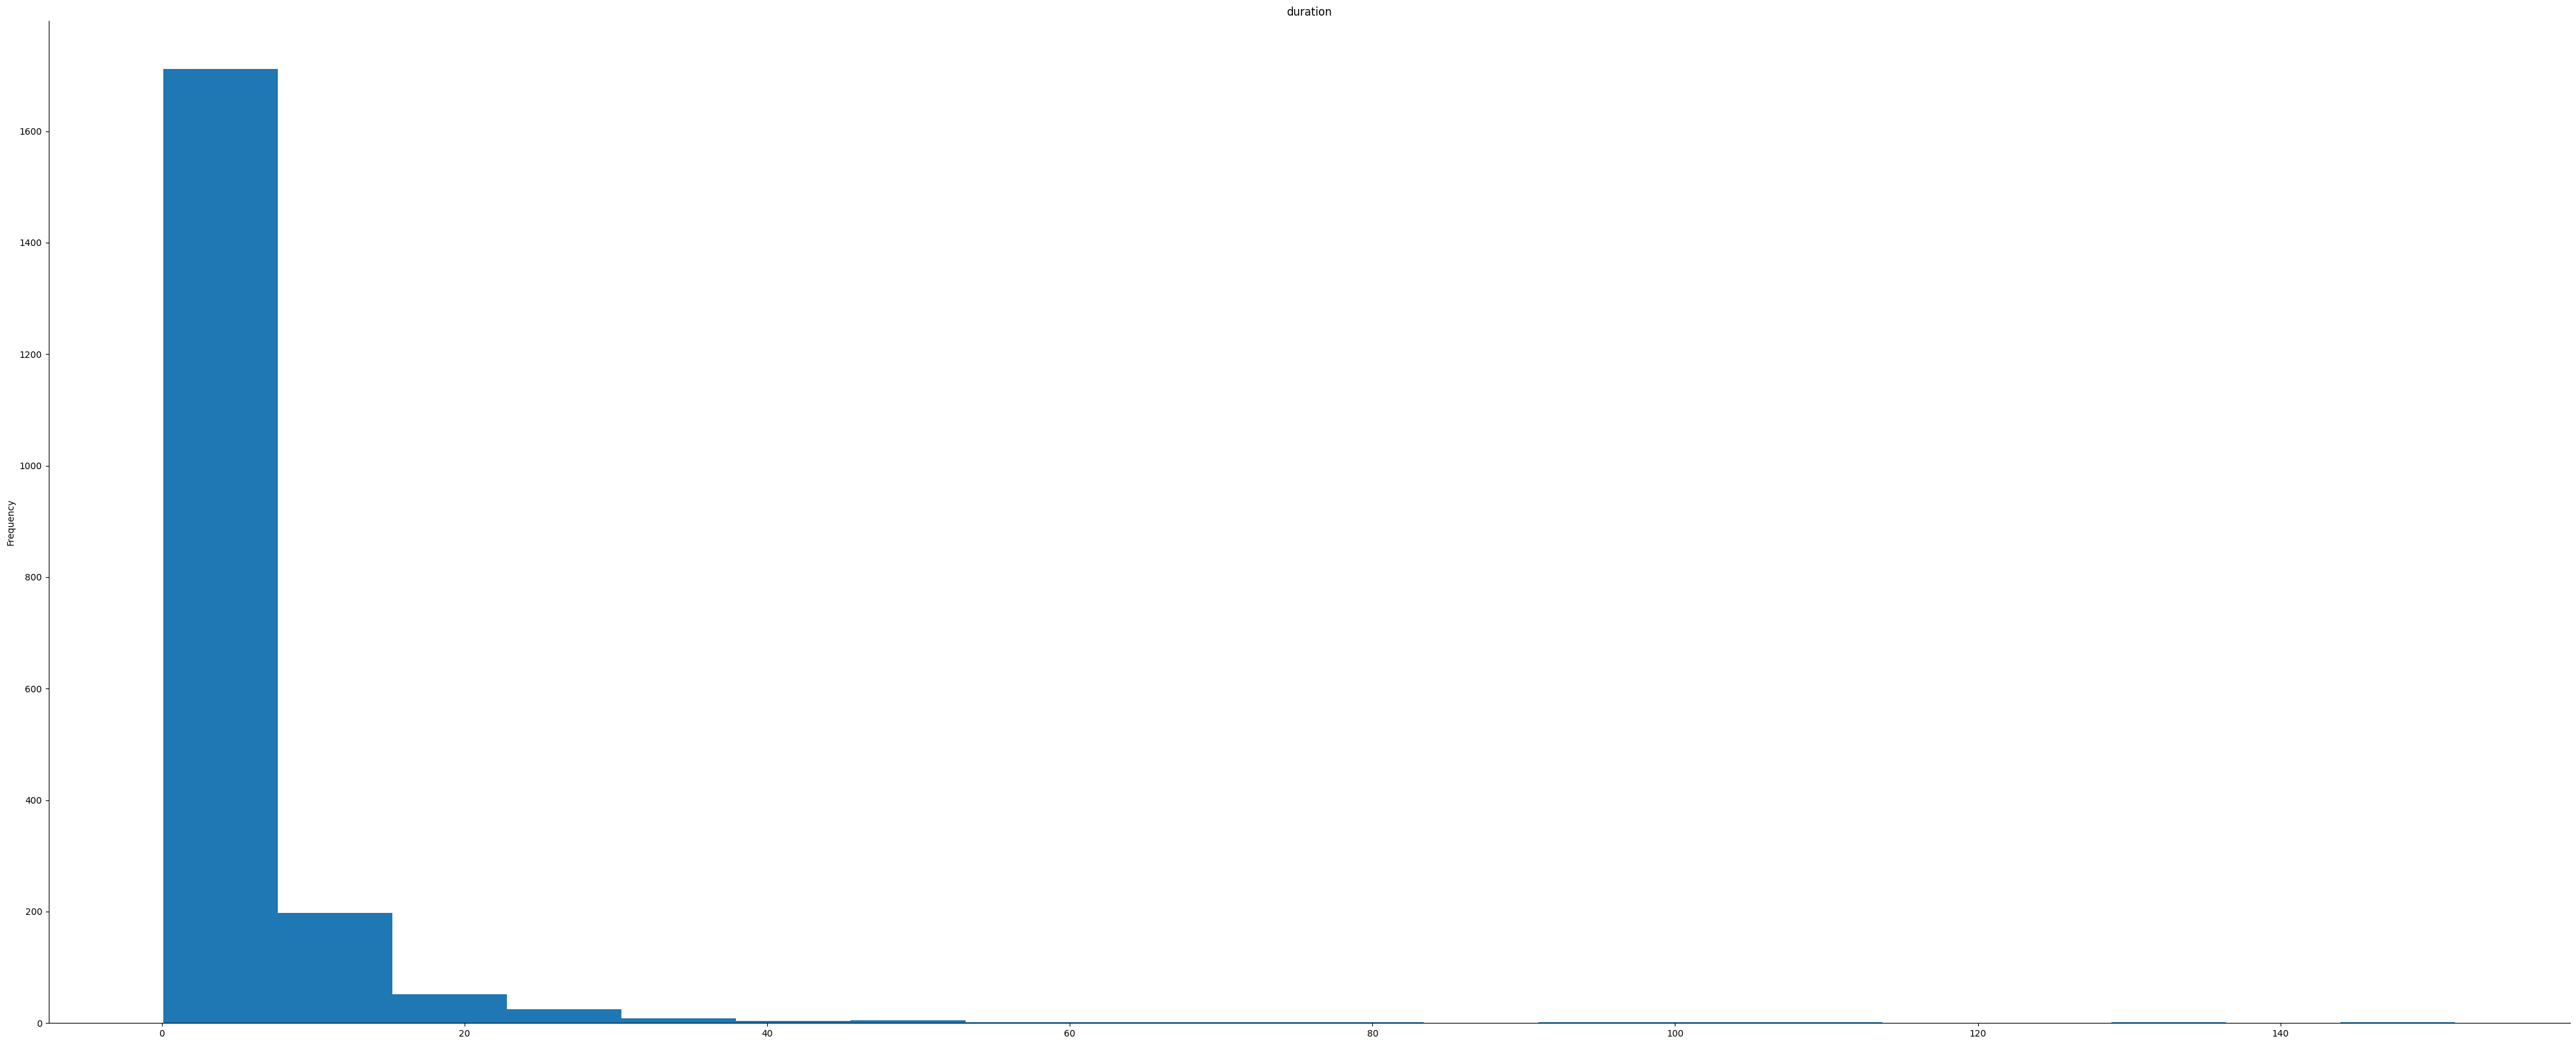

In [16]:
from matplotlib import pyplot as plt
resampled_df['duration'].plot(kind='hist', bins=20, title='duration')
plt.gca().spines[['top', 'right',]].set_visible(False)

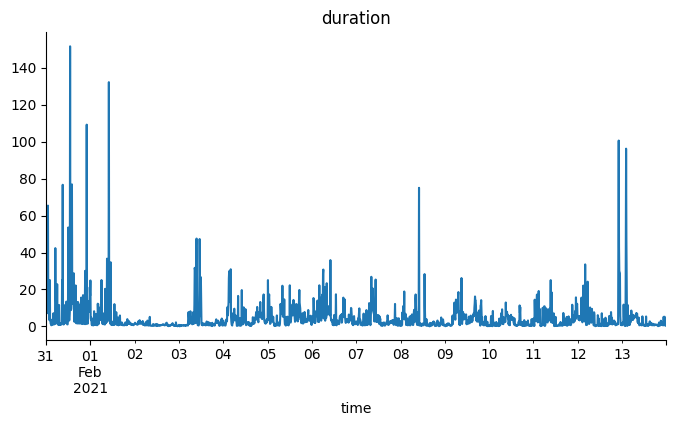

In [17]:
from matplotlib import pyplot as plt
resampled_df['duration'].plot(kind='line', figsize=(8, 4), title='duration')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Save the duration dataframe to an output csv:
# resampled_df.to_csv("/content/drive/MyDrive/AzureFunctionsInvocationTraceForTwoWeeksJan2021_resampled.csv", index=True)

## Preparing func seperated data
Now we are going to prepare a dictionary of dataframes to use
where the keys are the function ids and the values are the
grouped dataframes.

In [18]:
# Create the empty dictionary
func_to_df = {}

# Create the total time range
start_time = df['time'].min().floor('10T')
end_time = df['time'].max().ceil('10T')
all_time_bins = pd.date_range(start=start_time, end=end_time, freq='10T')

# Group the raw data by function id
func_groups = df.groupby('func')

# Iterate through each group and apply the binning and grouping logic
for func_id, func_data in func_groups:
    # Bin the timestamps into 10-minute intervals
    func_data['time_bin'] = func_data['time'].dt.floor('10T')

    # Group by the binned intervals and count the number of rows
    grouped_func_data = func_data.groupby('time_bin').size().reset_index(name='count')

    # Set the binned intervals as the index (optional)
    grouped_func_data.set_index('time_bin', inplace=True)

    # Reindex to include all time bins, filling missing bins with 0
    grouped_func_data = grouped_func_data.reindex(all_time_bins, fill_value=0)

    # Store the grouped DataFrame in the dictionary
    func_to_df[func_id] = grouped_func_data

<ipython-input-18-fd11a59f35e9>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  start_time = df['time'].min().floor('10T')
<ipython-input-18-fd11a59f35e9>:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  end_time = df['time'].max().ceil('10T')
<ipython-input-18-fd11a59f35e9>:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  all_time_bins = pd.date_range(start=start_time, end=end_time, freq='10T')
<ipython-input-18-fd11a59f35e9>:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  func_data['time_bin'] = func_data['time'].dt.floor('10T')
<ipython-input-18-fd11a59f35e9>:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  func_data['time_bin'] = func_data['time'].dt.floor('10T')
<ipython-input-18-fd11a59f35e9>:15: Futu

func_id:  003e28b4c0625b5c25f565828f9674f4119a852b5a0c22742f28b03534e15d95 2017
func_id:  022cdd4cd3ed0302a5ca116eccf280f1d19680123d58e001d04630605ba3e1f8 2017
func_id:  03e6f2ee02dabf9c7d4706ed3eef31ba6cbb3749b2f80d5524de2ade586aec5c 2017
func_id:  04102340c9da533c95612233f432fbb64b4134e341d030e1c1ddb7f968c10a69 2017
func_id:  042581128a262e8c0e5f8e109eefaa9304cc97790bbce7f42f02aa37f2df1ae5 2017
func_id:  045b3ad7f8e7a74d0906ef3f6e4405f9521e2944aa97764671b2d2535f799855 2017
func_id:  045cdc95c14c599e25a832fec0fd78f9b7a26f099f4de4d0642069587f9b9efb 2017
func_id:  04bf55f0a9d790ed3fd18c9960facdc85bca4e37974ccf0bb130d53936aac0c2 2017
func_id:  054956c96fac287df703cc443601502b4896a2546666cfb34461e221f9f57e26 2017
func_id:  056aa06c6d11538418e54e423171371ac2e6865f2c66fcb9e6b15be00d35e550 2017
func_id:  0684dcc2efebc6ee65bd74c97d80bcce49fb154d3659ec33605e404791c0cd75 2017
func_id:  081ea9c94c4ec36d1f840d4db940ef779416a350f49b06c37bb899c8da5dc2db 2017
func_id:  090691f051acb420d7663cd61db5ad

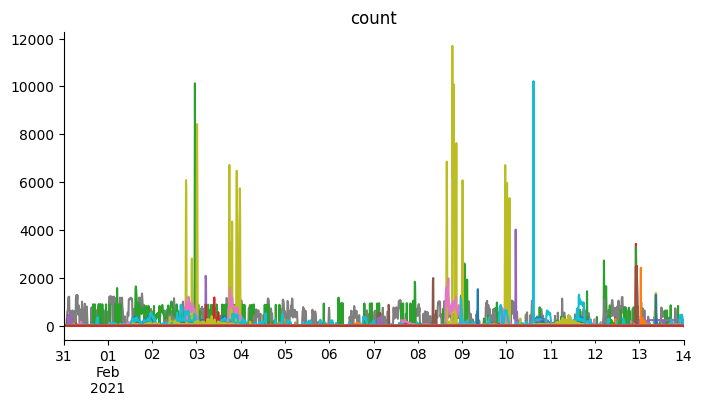

In [19]:
# Iterate through the dictionary and verify that the func specific data is correct

for func_id, func_data in func_to_df.items():
  print("func_id: ", func_id, len(func_data))

  # Adds all of them on the plot
  func_data['count'].plot(kind='line', figsize=(8, 4), title='count')
  plt.gca().spines[['top', 'right']].set_visible(False)


## Create Lookback Datasets
We need to create a lookback dataset, here we have the lookback as 10 for now.

In [20]:
def create_dataset(data, lookback = 10):
    X, y = [], []

    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])


    return np.array(X), np.array(y)

lookback = 20

### Duration normalized & lookback
Here we are going to create the lookback dataset for the duration dataset.

In [27]:
# First we normalize the data
resampled_df['log1p_duration'] = np.log1p(resampled_df['duration'])

# Now we create the resampled_df_X and resampled_df_y
resampled_df_X, resampled_df_y = create_dataset(resampled_df['log1p_duration'], lookback)

# Display relevant information
print("resampled_df_X", np.shape(resampled_df_X))
print("resampled_df_y", np.shape(resampled_df_y))
resampled_df.head()

<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


resampled_df_X (1996, 20)
resampled_df_y (1996,)


,duration,log1p_duration
time,,
2021-01-31 00:00:00,55.728184,4.038271
2021-01-31 00:10:00,52.744311,3.984238
2021-01-31 00:20:00,7.938605,2.190380
2021-01-31 00:30:00,7.149630,2.097972
2021-01-31 00:40:00,10.520867,2.444160


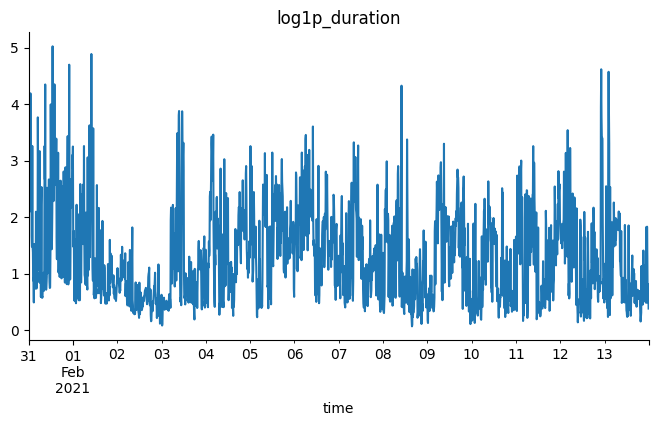

In [25]:
from matplotlib import pyplot as plt
resampled_df['log1p_duration'].plot(kind='line', figsize=(8, 4), title='log1p_duration')
plt.gca().spines[['top', 'right']].set_visible(False)

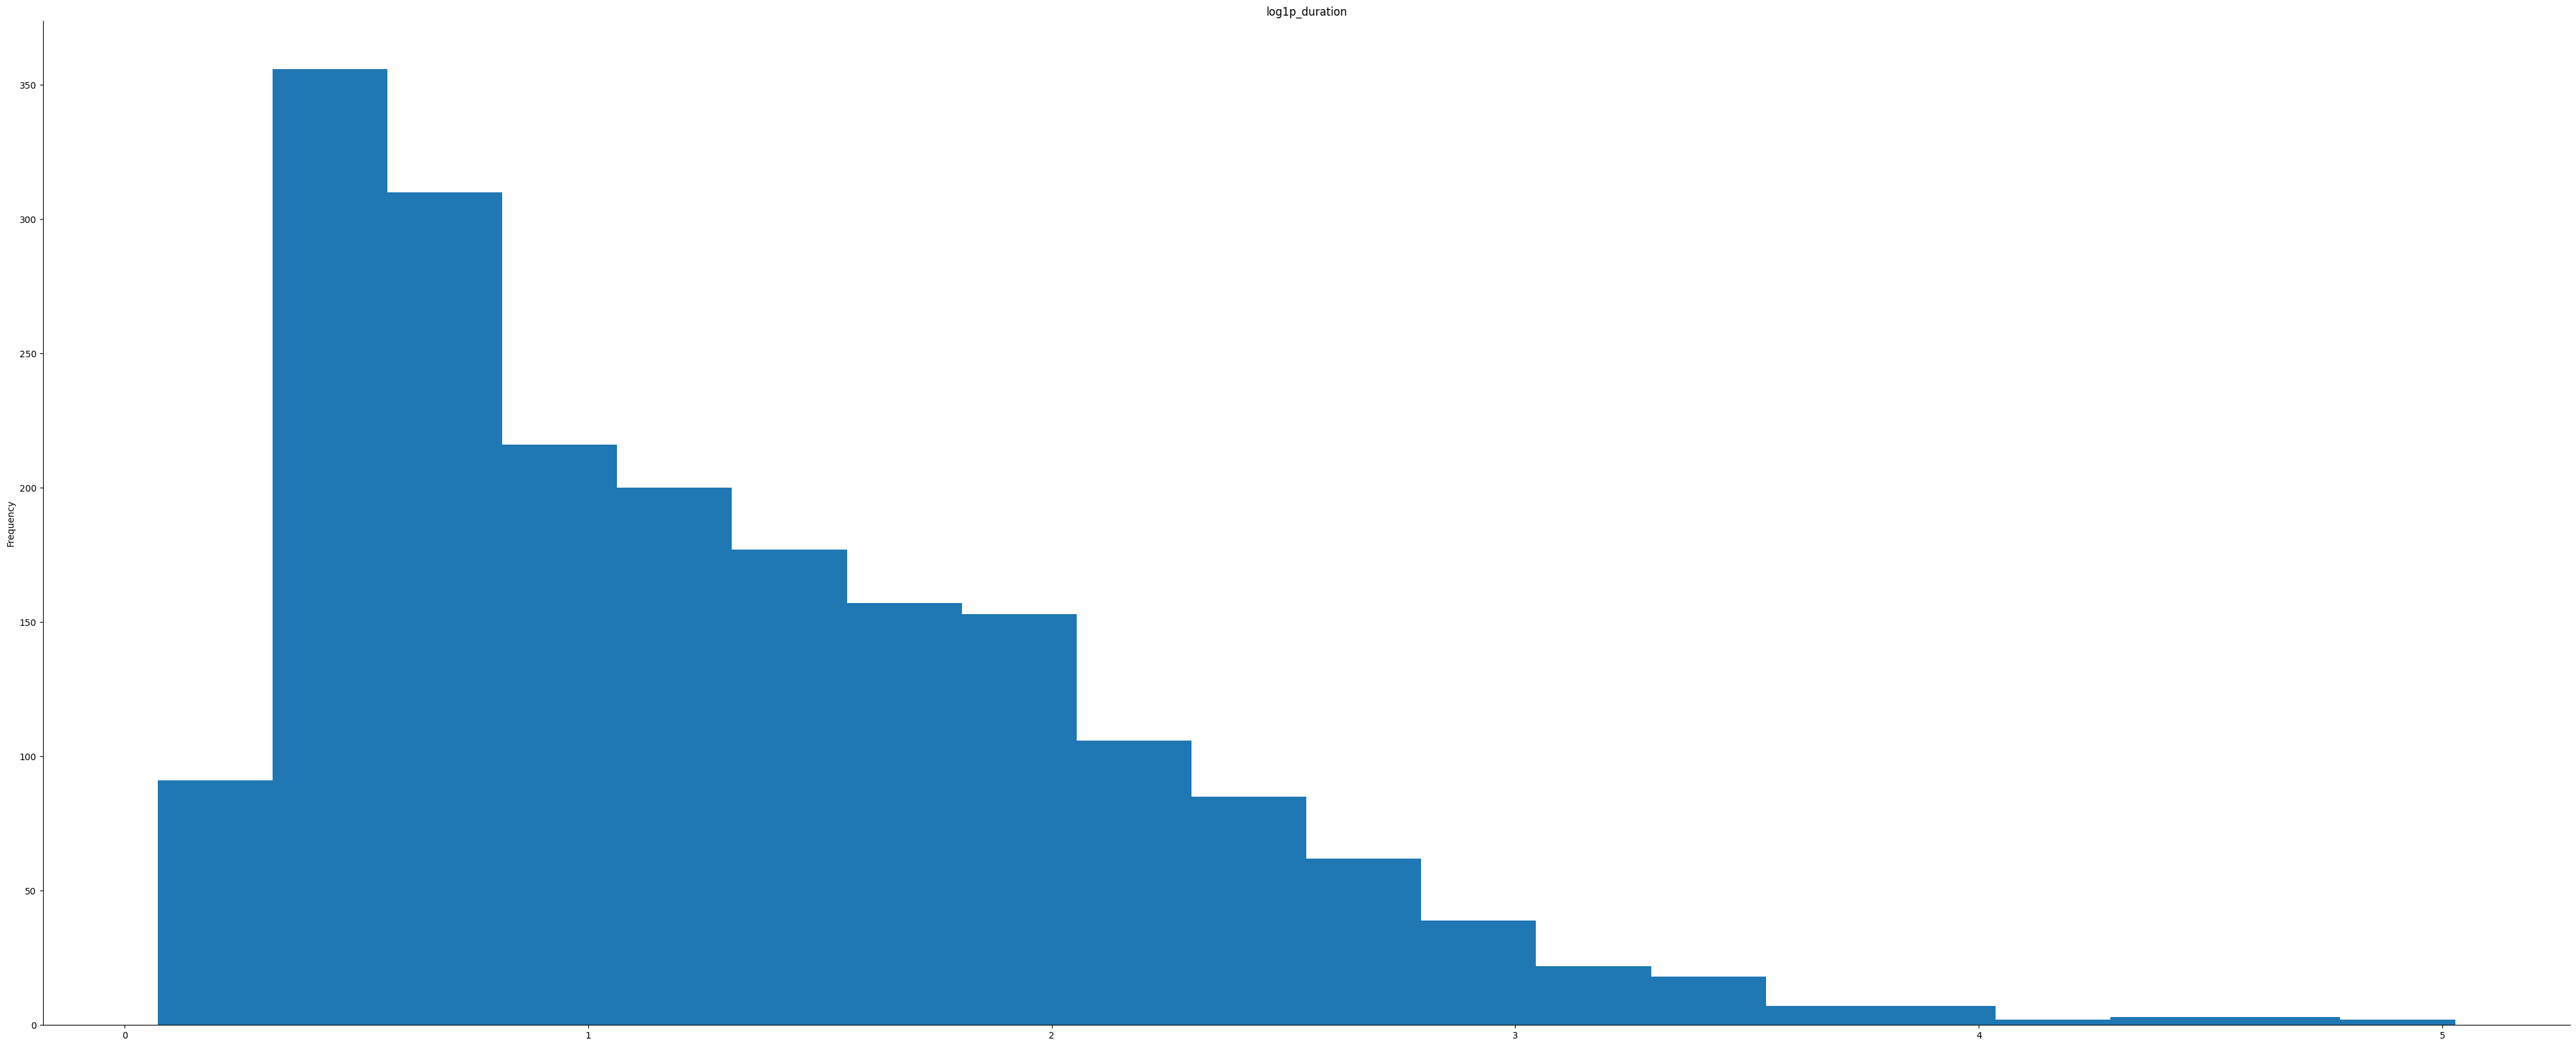

In [26]:
from matplotlib import pyplot as plt
resampled_df['log1p_duration'].plot(kind='hist', bins=20, title='log1p_duration')
plt.gca().spines[['top', 'right',]].set_visible(False)

### all_func_grouped Normalized & Lookback

Here we are going to create a lookback dataset for all the functions added together.

In [28]:
# First we need to normalize the data
all_func_grouped['log1p_count'] = np.log1p(all_func_grouped['count'])

# Now we create the all_func_grouped_X and all_func_grouped_y
all_func_grouped_X, all_func_grouped_y = create_dataset(all_func_grouped['log1p_count'], lookback)

# Display relevant information
print("all_func_grouped_X", np.shape(all_func_grouped_X))
print("all_func_grouped_y", np.shape(all_func_grouped_y))
all_func_grouped.head()


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


all_func_grouped_X (1996, 20)
all_func_grouped_y (1996,)


,count,log1p_count
time_bin,,
2021-01-31 00:00:00,103,4.644391
2021-01-31 00:10:00,90,4.510860
2021-01-31 00:20:00,124,4.828314
2021-01-31 00:30:00,135,4.912655
2021-01-31 00:40:00,90,4.510860


### func seperated data normalized & lookback

Here we are going to create a lookback dataset for all the functions added together.

In [29]:
func_to_df_X = {}
func_to_df_y = {}

for func_id, func_data in func_to_df.items():
  # First we need to normalize the data
  func_data['log1p_count'] = np.log1p(func_data['count'])
  func_to_df[func_id] = func_data  # Update df with log norm

  # Now we create the func_data_X and func_data_y
  func_data_X, func_data_y = create_dataset(func_data['log1p_count'], lookback)

  # Populate the X and Y dictionaries
  func_to_df_X[func_id] = func_data_X
  func_to_df_y[func_id] = func_data_y

  # Display relevant information
  print("func_data_X", np.shape(func_data_X))
  print("func_data_y", np.shape(func_data_y))
  all_func_grouped.head()

print("func_to_df_X: ", len(func_to_df_X))
print("func_to_df_y: ", len(func_to_df_y))

<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y 

<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


(1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])
<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)


<ipython-input-20-bccf7fd8d9e7>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


func_data_X (1997, 20)
func_data_y (1997,)
func_to_df_X:  424
func_to_df_y:  424


## Creating a Train, Valid, & Test subset

We are going to follow this pattern:



*   First 60% is Train
*   Next 20% is Validation
*   Last 20% is Test



### duration train, val, test

In [33]:
train_size = int(0.6 * len(resampled_df_X))   # First 70% for training
val_size = int(0.2 * len(resampled_df_X))    # Next 15% for validation
test_size = len(resampled_df_X) - train_size - val_size  # Remaining 15% for testing

# Split the data into train, validation, and test sets
X_train, X_val, X_test = resampled_df_X[:train_size], resampled_df_X[train_size:train_size+val_size], resampled_df_X[train_size+val_size:]
y_train, y_val, y_test = resampled_df_y[:train_size], resampled_df_y[train_size:train_size+val_size], resampled_df_y[train_size+val_size:]

# Split timestamps into train, validation, and test
lookback_timestamps = resampled_df.index[lookback:];
train_timestamps = lookback_timestamps[:train_size];
val_timestamps = lookback_timestamps[train_size:train_size + val_size];
test_timestamps = lookback_timestamps[train_size+val_size:];

# Reshape X_train, X_val, and X_test from 2D (samples, lookback) to 3D shape (samples, lookback, features=1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Print the sizes of each dataset to confirm
print("Train", X_train.shape, y_train.shape, train_timestamps.shape);
print("Validation", X_val.shape, y_val.shape, val_timestamps.shape);
print("Test", X_test.shape, y_test.shape, test_timestamps.shape);

Train (1197, 20, 1) (1197,) (1197,)
Validation (399, 20, 1) (399,) (399,)
Test (400, 20, 1) (400,) (400,)


### Visualize the Duration Data Split

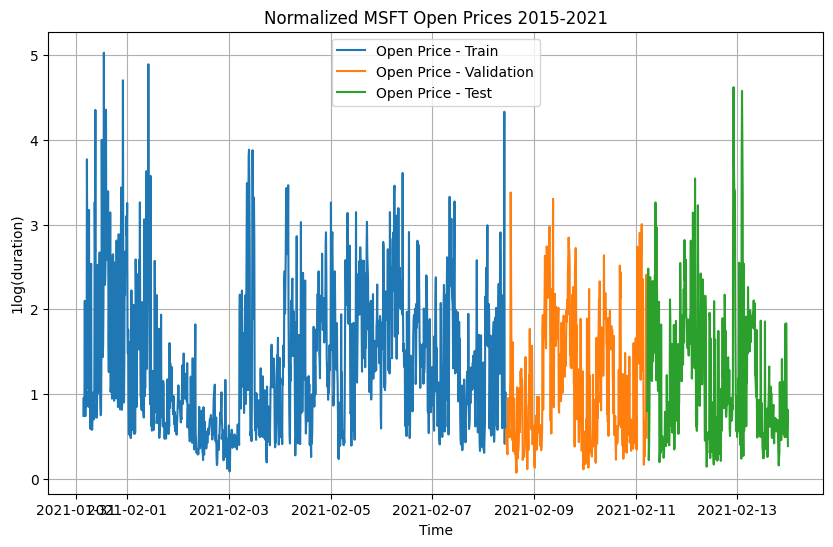

In [35]:
# Plot the Normalized Data Splits
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(train_timestamps, y_train, label='Open Price - Train')
plt.plot(val_timestamps, y_val, label='Open Price - Validation')
plt.plot(test_timestamps, y_test, label='Open Price - Test')


# Adding labels and title
plt.xlabel('Time')
plt.ylabel('1log(duration)')
plt.title('Normalized MSFT Open Prices 2015-2021')
plt.grid(True)
plt.legend()
plt.show()

# Defining CNN Architecture

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Declare the TF Keras Model
cnn_model = tf.keras.models.Sequential([

  # Add Conv1D layers
  Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(lookback, 1)),
  MaxPooling1D(pool_size=2),  # Downsample by 2

  Conv1D(filters=64, kernel_size=3, activation='relu'),
  MaxPooling1D(pool_size=2),

  # Flatten the 2D feature maps into a 1D vector
  Flatten(),

  # Fully connected layers
  Dense(128, activation='relu'),
  # Dropout(0.3),  # Regularization to prevent overfitting

  # Output layer for regression
  Dense(1)  # Single output for continuous regression
])

cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 18, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 7, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,169 (121.75 KB)

 Trainable params: 31,169 (121.75 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
from tensorflow.keras.optimizers import Adam

# Compile the model
LEARNING_RATE = 1e-5
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS = 'mean_squared_error'

cnn_model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS
)

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameters
EPOCHS = 1500
BATCH_SIZE = 30


# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train your model
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],  # Early stopping
    shuffle=False  # Turn off shuffling
)

Epoch 1/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.9496 - val_loss: 1.2520
Epoch 2/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7583 - val_loss: 1.1312
Epoch 3/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5776 - val_loss: 1.0209
Epoch 4/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4119 - val_loss: 0.9220
Epoch 5/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2641 - val_loss: 0.8361
Epoch 6/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1357 - val_loss: 0.7633
Epoch 7/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0267 - val_loss: 0.7029
Epoch 8/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9367 - val_loss: 0.6545
Epoch 9/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8648 - val_loss: 0.6168
Epoch 10/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8094 - val_loss: 0.5890
Epoch 11/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7686 - val_loss: 0.5696
Epoch 12/1500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/ste

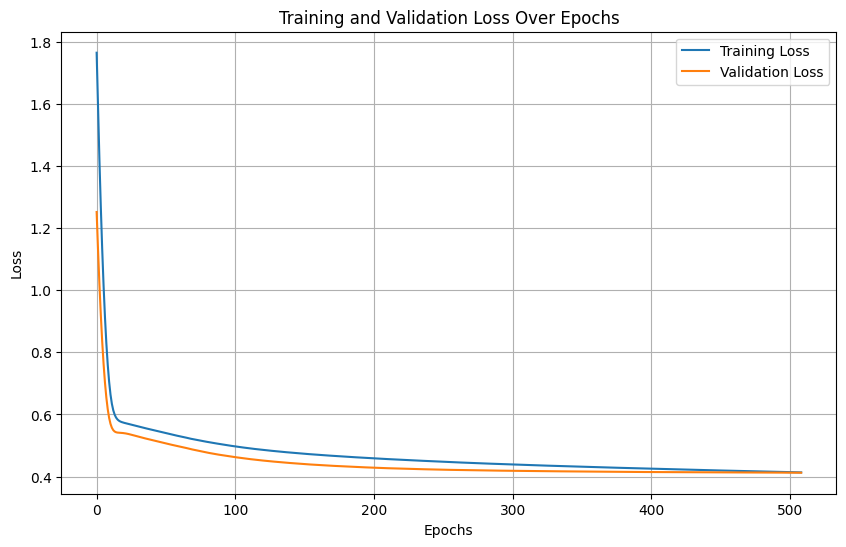

In [69]:
# Extract the loss values for training and validation
train_loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add labels and title
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [72]:
# Generate predictions for training, validation, and test data
y_train_pred_norm = cnn_model.predict(X_train)
y_val_pred_norm = cnn_model.predict(X_val)
y_test_pred_norm = cnn_model.predict(X_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Training Loss: 0.41277653
Validation Loss: 0.41219172
Test Loss: 0.56759435


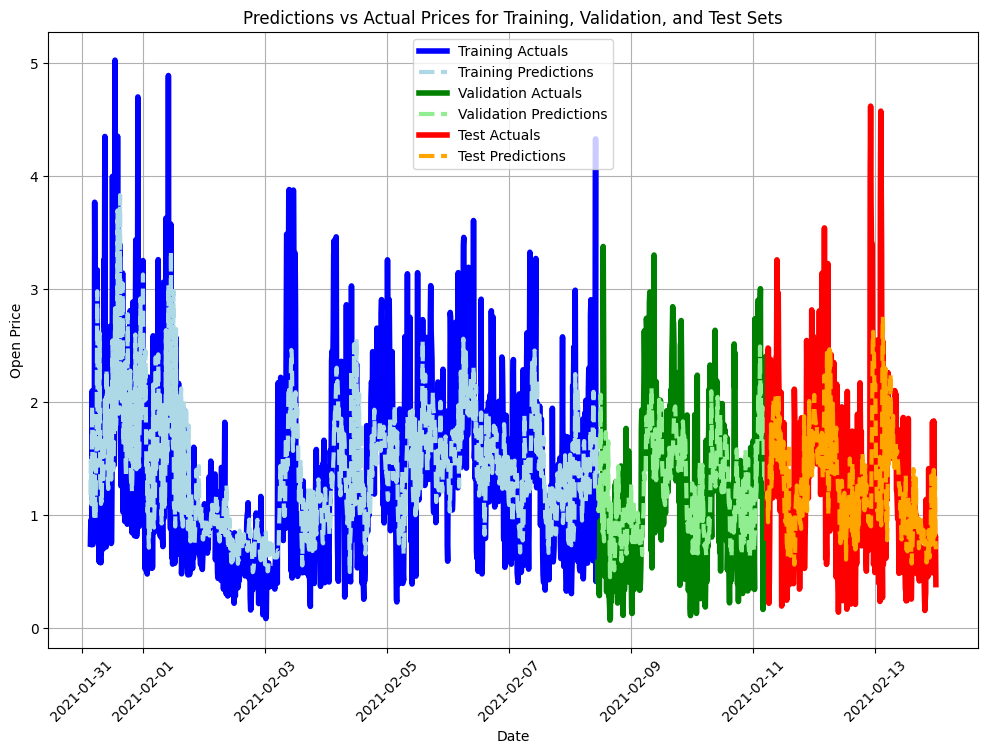

In [73]:
# Create MSE loss function
mse_loss = tf.keras.losses.MeanSquaredError()

# Calculate mean squared error for each dataset
train_loss = mse_loss(y_train, y_train_pred_norm).numpy()
val_loss = mse_loss(y_val, y_val_pred_norm).numpy()
test_loss = mse_loss(y_test, y_test_pred_norm).numpy()

print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)
print("Test Loss:", test_loss)


# Plotting the predictions and actual values
plt.figure(figsize=(12, 8))

# Plot for training data
plt.plot(train_timestamps, y_train, label='Training Actuals',
         color='blue', linewidth = 4)
plt.plot(train_timestamps, y_train_pred_norm, label='Training Predictions',
         color='lightblue', linestyle='--', linewidth = 3)

# Plot for validation data
plt.plot(val_timestamps, y_val, label='Validation Actuals',
         color='green', linewidth = 4)
plt.plot(val_timestamps, y_val_pred_norm, label='Validation Predictions',
         color='lightgreen', linestyle='--', linewidth = 3)

# Plot for test data
plt.plot(test_timestamps, y_test, label='Test Actuals',
         color='red', linewidth = 4)
plt.plot(test_timestamps, y_test_pred_norm, label='Test Predictions',
         color='orange', linestyle='--', linewidth = 3)

# Add labels, legend, and grid
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Predictions vs Actual Prices for Training, Validation, and Test Sets')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()